### Imports

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import sys
import wave
import copy
import math
import tensorflow as tf
from keras.models import Sequential, Model, load_model
from keras.layers.core import Dense, Activation
# from keras.layers import LSTM, Input, Flatten, Merge, Bidirectional
from keras.layers import LSTM, Input, Flatten, Bidirectional
from sklearn.preprocessing import label_binarize

from features import *
from helper import *
%matplotlib inline

# LSTM Audio Only Model
In this notebook we set up and test the audio only lstm model from the paper ...

In [14]:
# set up global variable
code_path = os.path.dirname(os.path.realpath(os.getcwd()))
data_path = code_path + "/../data/"
sessions = ['Session1', 'Session2', 'Session3', 'Session4', 'Session5']
framerate = 16000

For this model, we will predict over the emotions
Anger,
Excitement,
Sadness

We also predict for neutral emotions, meaning no strong emotion is present

In [15]:
emotions_used = np.array(['ang', 'exc', 'neu', 'sad'])


### Set up data
We are using the IEMOCAP dataset, this includes:
audio,
transcription,
motion capture,
and video for a number of scripted and improvised scenarios

In [16]:
# Load in data
import pickle5
with open("../../../data/data_collected.pickle", 'rb') as handle:
    data2 = pickle5.load(handle)


### Feature extraction
These are a number of features that are extracted from the wav audio segments

1. The temporal features (time domain features):

* zero crossing rate
* energy
* entropy of energy

2. The spectral features (frequency based features):
* spectral centroid
* spectral spread
* spectral entropy
* spectral flux
* spectral rolloff

3. 13 MFCC bands


4. Chroma features (__Always seem to evaluate to 0__)
* 13 Chroma
* 12-dimensional chroma vector
* standard deviation of chroma vector

In [17]:
# this method is used to extract features from the input wav
# def calculate_features(frames, freq, options):
#     window_sec = 0.1
#     window_n = int(freq * window_sec)
#
#     st_f = stFeatureExtraction(frames, freq, window_n, window_n / 2)
#
#     if st_f.shape[1] > 2:
#         i0 = 1
#         i1 = st_f.shape[1] - 1
#         if i1 - i0 < 1:
#             i1 = i0 + 1
#
#         deriv_st_f = np.zeros((st_f.shape[0], i1 - i0), dtype=float)
#         for i in range(i0, i1):
#             i_left = i - 1
#             i_right = i + 1
#             deriv_st_f[:st_f.shape[0], i - i0] = st_f[:, i]
#         return deriv_st_f
#     elif st_f.shape[1] == 2:
#         deriv_st_f = np.zeros((st_f.shape[0], 1), dtype=float)
#         deriv_st_f[:st_f.shape[0], 0] = st_f[:, 0]
#         return deriv_st_f
#     else:
#         deriv_st_f = np.zeros((st_f.shape[0], 1), dtype=float)
#         deriv_st_f[:st_f.shape[0], 0] = st_f[:, 0]
#         return deriv_st_f

In [18]:
# generating training data take a while, here we load the training data into the np array from a file
x_train_file = "Trained_models/x_test_speech.npy"

load = True

if load:
    with open(x_train_file, 'rb') as f:
        x_train_speech = np.load(f)
else:
    # set up the training set
    x_train_speech = []
    
    counter = 0
    for ses_mod in data2:
        x_head = ses_mod['signal']
        st_features = calculate_features(x_head, framerate, None)
        st_features, _ = pad_sequence_into_array(st_features, maxlen=100)
        x_train_speech.append( st_features.T )

    x_train_speech = np.array(x_train_speech)
    x_train_speech.shape

    # save model after it has been trained
    with open(x_train_file, 'wb') as f:
        np.save(f, x_train_speech)

x_train_speech.shape

(4936, 100, 34)

### The LSTM Model

The audio only model that is implemented here is a 2 layer LSTM model connected to a dense layer.

A softmax function is used to get the confidence rating for each class.

In [19]:
def lstm_model(optimizer='Adadelta'):
    model = Sequential()
    model.add(LSTM(512, return_sequences=True, input_shape=(100, 34)))
    model.add(LSTM(256, return_sequences=False))
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dense(4))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

In [20]:
model = lstm_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100, 512)          1120256   
_________________________________________________________________
lstm_4 (LSTM)                (None, 256)               787456    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               131584    
_________________________________________________________________
activation_3 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 2052      
_________________________________________________________________
activation_4 (Activation)    (None, 4)                 0         
Total params: 2,041,348
Trainable params: 2,041,348
Non-trainable params: 0
____________________________________________

In [21]:
# split labels from training data
Y_raw =[]
for ses_mod in data2:
    Y_raw  .append(ses_mod['emotion'])


#converts labels into a one hot encoded version
Y = label_binarize(Y_raw ,emotions_used)

Y.shape

F:\Program Files\Ananconda\envs\CAP\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=['ang' 'exc' 'neu' 'sad'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


(4936, 4)

### Training the model
Training on about 5000 rows over 40 epochs takes about 80 minutes.
To avoid retraining the model every time, we have exported the model into a pickle file.

In [22]:
# save / load model from pickle file

#model.save("Trained_models/2_layer_LSTM.pickle")
model = load_model("Trained_models/2_layer_LSTM.pickle")

In [23]:
# train model

# hist = model.fit(x_train_speech, Y,
#                  batch_size=100, nb_epoch=40, verbose=1, shuffle = True,
#                  validation_split=0.2)


### Evaluating the Model
This trained model has an accuracy of 54.4%.

In [24]:
print("Evaluate on test data")
results = model.evaluate(x_train_speech[0:10], Y[0:10], batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
10/10 [==============================] - 0s 23ms/step
test loss, test acc: [1.040794014930725, 0.699999988079071]


In [25]:
predict_result_file = "Trained_models/predict_result.npy"

load = True

if load:
    with open(predict_result_file, 'rb') as f:
        result = np.load(f)
else:
    result = model.predict(x_train_speech)
    with open(predict_result_file, 'wb') as f:
        np.save(f, result)

In [26]:
# get prediction values for training data
label = tf.argmax(result, axis = 1)

#### We have to convert the encoded emotion labels back into a more readable format.

In [27]:
# formatting the label data
cols = ['ang', 'exc', 'neu', 'sad']
col_y = []
df_real = pd.DataFrame(Y_raw, columns = ["emotion"])
for val in df_real["emotion"].values:
    x = 0
    for c in range(0,len(cols)):
        if cols[c] in val:
            col_y.append(c)
            break

df_real["val"] = col_y
print("Actual Labels")
df_real.head()

Actual Labels


,emotion,val
0,neu,2
1,neu,2
2,neu,2
3,neu,2
4,ang,0


In [28]:
# formatting the predicted data
cols = ['ang', 'exc', 'neu', 'sad']
col_y = []
df_pred = pd.DataFrame(label, columns=["val"])
for x in df_pred["val"].values:
    col_y.append(cols[x])

df_pred["emotion"] = col_y
print("Prediction Data")
df_pred.head()


Prediction Data


,val,emotion
0,2,neu
1,2,neu
2,2,neu
3,0,ang
4,0,ang


### Dataset investigation

Looking into the distribution of the dataset, we can see a clear unbalance between neutral samples and samples that indicate a specific emotion.
Although this may make the model more likely to guess that a sample is neutral, this is representative of real conversation.

Text(0.5, 1.0, 'Distribution of classes in input data')

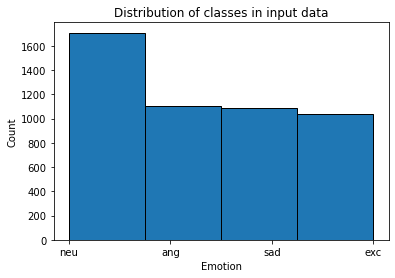

In [29]:
pd.DataFrame(Y_raw).head()
## Plot emotion histogram for input data
plt.hist(Y_raw, bins=4, ec="black")  # `density=False` would make counts
plt.ylabel('Count')
plt.xlabel('Emotion')
plt.title("Distribution of classes in input data")

Text(0.5, 1.0, 'Distribution of classes in prediction data')

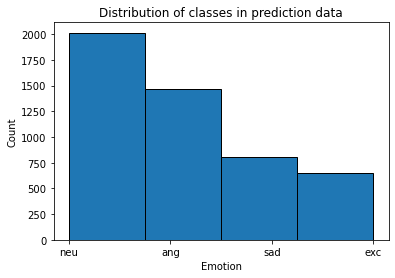

In [30]:
# 
plt.hist(df_pred["emotion"], bins=4, ec="black")
plt.ylabel('Count')
plt.xlabel('Emotion')
plt.title("Distribution of classes in prediction data")

### Confusion matrix

Text(0.5, 1.0, 'Confusion matrix of mean confidence')

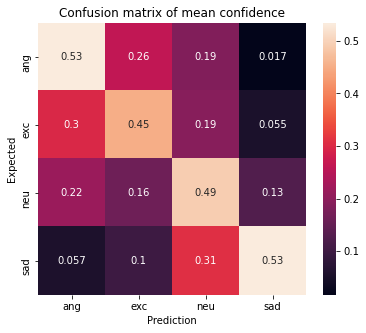

In [31]:
import seaborn as sn
emotions = ['ang', 'exc', 'neu', 'sad']
## get avg between classes
df_res = pd.DataFrame(result)
df_label = pd.DataFrame(label)

df_emotion_conf = pd.DataFrame()

df_res.columns = emotions

df_res["emo"] = df_label[0]
df_emotion_conf = df_res.groupby(['emo']).mean()
df_emotion_conf["emo"] = emotions
df_emotion_conf = df_emotion_conf.set_index("emo")


plt.figure(figsize = (6, 5))
sn.heatmap(df_emotion_conf, annot=True)
plt.xlabel("Prediction")
plt.ylabel("Expected")
plt.title("Confusion matrix of mean confidence")

## Loading in new Wav file

In [1]:
import IPython.display as ipd
audio_path = "F:/Capstone Project/IEMOCAP-Emotion-Detection/data/CMU_MOSI/Raw/Audio/WAV_11025/"
file_name = "PZ-lDQFboO8.wav"

#ipd.Audio(audio_path + file_name) # load a local WAV file

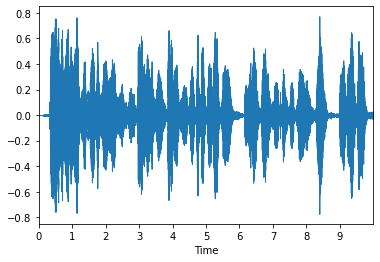

In [4]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
y, sr = librosa.load(audio_path + file_name, duration=10)
fig, ax = plt.subplots()
librosa.display.waveplot(y, sr=sr)
ax.label_outer()

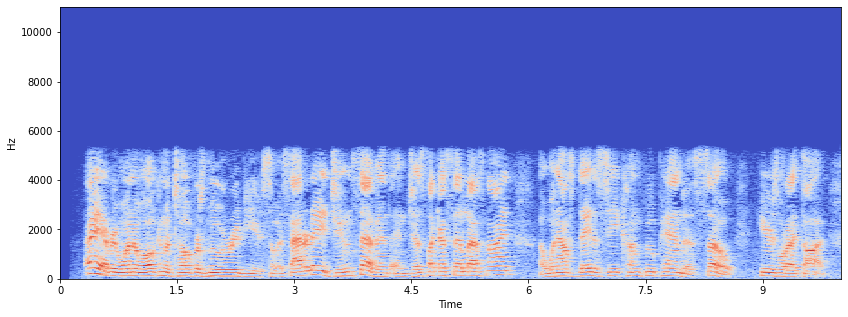

In [5]:
X = librosa.stft(y)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')

In [35]:
wav = get_audio(audio_path, file_name)
(nchannels, sampwidth, framerate, nframes, comptype, compname), samples_wav = wav

#### Splitting the Wav into samples
after loading in a wav file to test on, we will be splitting it into a number of samples.
Each sample will be a 3 second slice of the original wav (The slice length can be changed by changing the timeq).
An overlap can also be used between samples, for this test we use a 1 second overlap

In [36]:
len_wav = nframes / framerate # length of wav in seconds

timeq = 3 # length of sample slice in seconds
overlap = 1 # overlap between samples

left = samples_wav[0::nchannels]
right = samples_wav[1::nchannels]

samples = []
for t_start in range(0, int(len_wav), int(timeq)):
    if t_start > int(t_start):
        t_start = t_start

    if t_start == 0: #first sample
        start = t_start
        end = t_start + timeq
    else:
        start = t_start - overlap
        end = t_start + timeq - overlap

    if end > len_wav:
        end = len_wav
    sample_right = right[int(start * framerate):int(end * framerate)]
    sample_left = left[int(start * framerate):int(end * framerate)]
    # print("sample start: " + str(start) + " | sample end: " + str(end))

    #normalize data
    norm = np.linalg.norm(sample_left)
    normal_array = sample_left/norm

    samples.append(normal_array) #, 'right': sample_right})

#### Extracting features

In [37]:
# set up the training set
wav_in = []

counter = 0
for ses_mod in samples:
    st_features = calculate_features(ses_mod, framerate, None)
    st_features, _ = pad_sequence_into_array(st_features, maxlen=100)
    wav_in.append( st_features.T )

wav_in = np.array(wav_in)
wav_in.shape

(34, 100, 34)

#### Predict on model

In [38]:
import time
t0 = time.time()
wav_test_results = model.predict(wav_in)
print("time = " + str(time.time() - t0))
#wav_test_results

time = 0.8350005149841309


In [39]:
wav_test_results_max = tf.argmax(wav_test_results, axis = 1)
wav_test_results.shape

(34, 4)

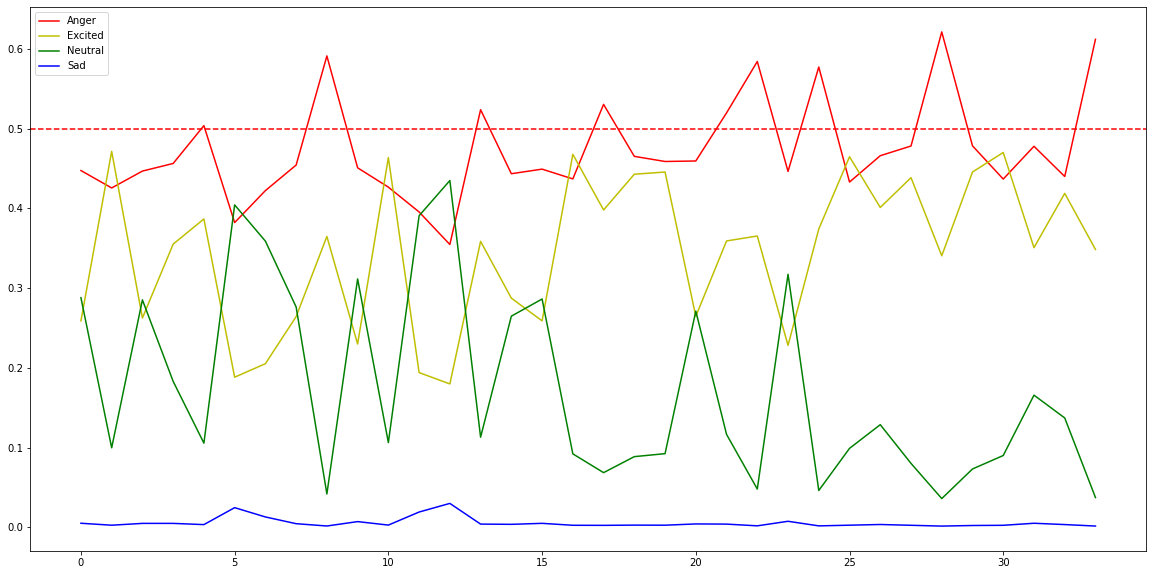

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt
# formatting the predicted data
cols = ['ang', 'exc', 'neu', 'sad']
col_y = []
df_pred_wav = pd.DataFrame(wav_test_results, columns=cols)

plt.figure(figsize=(20,10))
plt.plot(df_pred_wav['ang'], label="Anger", color='r')
plt.plot(df_pred_wav['exc'], label="Excited", color='y')
plt.plot(df_pred_wav['neu'], label="Neutral", color='g')
plt.plot(df_pred_wav['sad'], label="Sad", color='b')
plt.axhline(y=0.5, color='r', linestyle='--')
plt.legend(loc="upper left")
plt.show()

In [41]:
x_train_test = x_train_speech[0:101]
y_test = Y[0:101]
import time
t0 = time.time()
res = model.predict(x_train_test)
print("time = " + str(time.time() - t0))
df = pd.DataFrame(res, columns=['ang', 'exc', 'neu', 'sad'])

time = 1.5545313358306885


In [42]:
df.head()

,ang,exc,neu,sad
0,0.174889,0.117379,0.565304,0.142428
1,0.324314,0.178441,0.454979,0.042266
2,0.302033,0.169936,0.466192,0.061839
3,0.532878,0.191508,0.267675,0.007938
4,0.437967,0.416702,0.141551,0.003780


## Real Time Audio Predictions

Finished


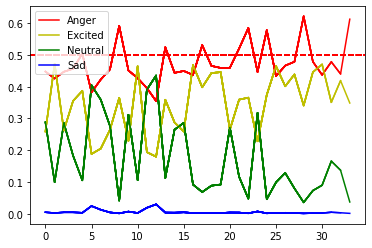

In [46]:
# %matplotlib tk
cols = ['ang', 'exc', 'neu', 'sad']
df_pred_wav = pd.DataFrame(columns=cols)
fig , ax = plt.subplots()
ax.plot([0], label="Anger", color='r')
ax.plot([0], label="Excited", color='y')
ax.plot([0], label="Neutral", color='g')
ax.plot([0], label="Sad", color='b')

    
plt.legend(loc="upper left")

# x = np.arange(0, 50)
# line, = ax.plot(x)


graph_window = 10
for ses_mod in samples:
    #time.sleep(0.2)
    # Extract Features
    
    wav_in = []
    st_features = calculate_features(ses_mod, framerate, None)
    st_features, _ = pad_sequence_into_array(st_features, maxlen=100)
    wav_in.append( st_features.T )
    wav_in = np.array(wav_in)
    
    t0 = time.time()
    wav_test_results = model.predict(wav_in)
#     print("time = " + str(time.time() - t0))
    #print("prediction = " + str(wav_test_results))
    
    df_pred_wav = df_pred_wav.append({cols[0]:wav_test_results[0][0],
                        cols[1]:wav_test_results[0][1],
                        cols[2]:wav_test_results[0][2],
                        cols[3]:wav_test_results[0][3]
    }, ignore_index=True)
    
    df_pred_wav_view = df_pred_wav[df_pred_wav.shape[0] - graph_window : ]
    
    #plt.cla()
    
    ax.axhline(y=0.5, color='r', linestyle='--')
    ax.plot(df_pred_wav_view['ang'], label="Anger", color='r')
    ax.plot(df_pred_wav_view['exc'], label="Excited", color='y')
    ax.plot(df_pred_wav_view['neu'], label="Neutral", color='g')
    ax.plot(df_pred_wav_view['sad'], label="Sad", color='b')
    
    fig.canvas.draw()
    fig.canvas.flush_events()
print("Finished")
    

In [44]:
type(ses_mod)

numpy.ndarray